#### Automation Engine 코드


In [ ]:
# !pip install -U sentence-transformers
# !pip install -U transformers

In [38]:
import asyncio
from crawling import RestClient, NewsCrawler
from datetime import datetime

from collections import Counter
from functools import reduce

import random
import numpy as np
import pandas as pd
import pymysql
from datetime import datetime, timedelta

from dotenv import load_dotenv
import os
from loguru import logger
import tenacity
from tqdm import tqdm, trange

load_dotenv()
tqdm.pandas()

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sentence_transformers import SentenceTransformer
import hdbscan

def fix_seed(seed = 42):
    random.seed(seed) # python random seed 고정
    np.random.seed(seed) # numpy random seed 고정
    torch.manual_seed(seed) # torch random seed 고정
    torch.cuda.manual_seed_all(seed)


class Engine:
    def __init__(self, db_user, db_password, db_host, topic_n, db_database='AUTOMATION', db_port=3306, period=24, day_diff = 0):
        # MySQL 서버 정보 설정
        self.db_config = {
            'user': db_user,
            'password': db_password,
            'host': db_host,
            'database': db_database,
            'port': int(db_port)  # MySQL 기본 포트
        }
        
        # topic_code에 사용되는 변수. 삼성전자_{topic_n}_0, 삼성전자_{topic_n}_1, 삼성전자_{topic_n}_2, ...   
        self.topic_n = topic_n
        
        # 수집하는 시간 업데이트
        if period == 24:
            self.today = (datetime.now() - timedelta(days=day_diff)).strftime('%Y-%m-%d')
            self.start_time = (datetime.now() - timedelta(days=day_diff)).replace(hour=0, minute=0, second=0, microsecond=0)
            self.end_time = (datetime.now() - timedelta(days=day_diff)).replace(hour=23, minute=59, second=59, microsecond=0)

        else:
            self.today = datetime.now().strftime('%Y-%m-%d')
            self.start_time = (datetime.now() - timedelta(hours=period)).replace(minute=0, second=0, microsecond=0)
            self.end_time = datetime.now().replace(minute=0, second=0, microsecond=0)
        
        logger.info(f"Automation Process Start : {self.start_time.strftime('%Y-%m-%d %H:%M:%S')} ~ {self.end_time.strftime('%Y-%m-%d %H:%M:%S')}")
    
    
    def db_connection(self):
        # MySQL 연결 설정
        connection = pymysql.connect(
            user=self.db_config['user'],
            password=self.db_config['password'],
            host=self.db_config['host'],
            database=self.db_config['database'],
            port=self.db_config['port'],
            cursorclass=pymysql.cursors.DictCursor  # 결과를 딕셔너리로 받기 위한 설정
        )
        
        return connection
    
    @tenacity.retry(wait=tenacity.wait_fixed(3), stop=tenacity.stop_after_attempt(5))
    def insert_data_to_db(self, query, data, description=''):
        try:
            connection = self.db_connection()
            with connection.cursor() as cursor:
                # 데이터 입력 및 커밋
                result = cursor.executemany(query, data)
                connection.commit()
        
        except Exception as e:
            logger.error(f"{description} | ERROR : {e}")
            raise ValueError(f'ERROR : {description}')    

        finally:
            connection.close()
    
    @tenacity.retry(wait=tenacity.wait_fixed(3), stop=tenacity.stop_after_attempt(5))
    def select_data_from_db(self, query, description=''):
        try:
            connection = self.db_connection()
            with connection.cursor() as cursor:
                cursor.execute(query)
                result = cursor.fetchall()
                
        except Exception as e:
            logger.error(f"{description} | ERROR : {e}")
            raise ValueError(f'ERROR : {description}')    

        finally:
            connection.close()
        
        return result
    
    
    def fill_company(self, path='./utils/company.csv') -> None:
        table_name = 'COMPANY'
        logger.info(f"INSERT {table_name} TABLE START")
        
        df = pd.read_csv(path)
        company_info = df.to_dict(orient='index')
        # to_dict 과정에서 정수로 구성된 문자열이 정수로 변함.
        company_info = [{'company_code' : '0'*(6-len(str(company_info[idx]['company_code']))) + str(company_info[idx]['company_code']), 
                            'name' : company_info[idx]['name'] } for idx in company_info]        
        
        self.insert_data_to_db(query = f"INSERT INTO {self.db_config['database']}.{table_name} (company_code, name) VALUES (%(company_code)s, %(name)s)",
                               data = company_info, 
                               description = f'INSERT {table_name} TABLE')
        
        logger.info(f"INSERT {table_name} TABLE DONE")
        
        
        
    async def fill_news(self):
        table_name = 'NEWS'
        start_time, end_time = self.start_time.strftime('%Y-%m-%d %H:%M:%S'), self.end_time.strftime('%Y-%m-%d %H:%M:%S')
        logger.info(f"INSERT {table_name} TABLE START : {start_time} ~ {end_time}")
        # 뉴스 데이터 크롤링.
        await self.crawling_news()
        logger.info(f"NEWS Crawling Done")
        
        # 수집한 데이터 로드 및 전처리
        news_info = self.preprocess_news()
        logger.info(f"NEWS Preprocessing Done")
        
        self.insert_data_to_db(query = f"INSERT INTO {self.db_config['database']}.{table_name} (date, url, title, contents, relate_stock) \
                                                            VALUES (%(date)s, %(url)s, %(title)s, %(contents)s, %(relate_stock)s)",
                               data = news_info, 
                               description = f'INSERT {table_name} TABLE')
        logger.info(f"INSERT {table_name} TABLE DONE : {start_time} ~ {end_time}")
    
    
    
    
    def fill_news_company(self):
        table_name = 'NEWS_COMPANY'
        start_time, end_time = self.start_time.strftime('%Y-%m-%d %H:%M:%S'), self.end_time.strftime('%Y-%m-%d %H:%M:%S')
        logger.info(f"INSERT {table_name} TABLE START : {start_time} ~ {end_time}")        
        # NEWS, COMPANY 데이터 조회, 
        news_data = self.select_data_from_db(query = f"SELECT * FROM {self.db_config['database']}.NEWS WHERE date BETWEEN '{start_time}' AND '{end_time}';", 
                                             description='SELECT NEWS TABLE')
        company_data = self.select_data_from_db(query = f"SELECT * FROM {self.db_config['database']}.COMPANY;",
                                                description='SELECT COMPANY TABLE')
        logger.info(f"NEWS, COMPANY SELECT Done")
        
        # NEWS_COMPANY 테이블에 맞게 전처리
        news_company_info = self.preprocess_news_company(news_data, company_data)
        logger.info(f"{table_name} Preprocessing Done")
        
        # NEWS_COMPANY 테이블에 입력
        self.insert_data_to_db(query=f"INSERT INTO {self.db_config['database']}.{table_name} (news_id, company_id) VALUES (%(news_id)s, %(company_id)s)",
                               data=news_company_info,
                               description=f'INSERT {table_name} TABLES')
        logger.info(f"INSERT {table_name} TABLE DONE : {start_time} ~ {end_time}")
    
    
    def fill_summary(self):
        table_name = 'SUMMARY'
        start_time, end_time = self.start_time.strftime('%Y-%m-%d %H:%M:%S'), self.end_time.strftime('%Y-%m-%d %H:%M:%S')
        logger.info(f"INSERT {table_name} TABLE START : {start_time} ~ {end_time}")
        # NEWS, COMPANY 데이터 조회, 
        news_data = self.select_data_from_db(query = f"SELECT * FROM {self.db_config['database']}.NEWS WHERE date BETWEEN '{start_time}' AND '{end_time}';", 
                                             description='SELECT NEWS TABLE')
        logger.info(f"NEWS SELECT Done")
        
        # NEWS 요약 데이터 생성
        summary_info = self.preprocess_summary(news_data=news_data, 
                                               model_path= './model/summary/summary_model.pt',
                                               pretrained_model_name_or_path="ainize/kobart-news")
        logger.info(f"NEWS {table_name} Done")
        
        # SUMMARY TABLE에 데이터 입력
        self.insert_data_to_db(query=f"INSERT INTO {self.db_config['database']}.{table_name} (news_id, summary_text) VALUES (%(news_id)s, %(summary_text)s)",
                               data = summary_info,
                               description=f'INSERT {table_name} TABLES')
        logger.info(f"INSERT {table_name} TABLE END : {start_time} ~ {end_time}")

        
    
    def fill_sentiment(self):
        table_name = 'SENTIMENT'
        start_time, end_time = self.start_time.strftime('%Y-%m-%d %H:%M:%S'), self.end_time.strftime('%Y-%m-%d %H:%M:%S')
        logger.info(f"INSERT SENTIMENT TABLE START : {start_time} ~ {end_time}")
        
        # NEWS, COMPANY 데이터 조회, 
        news_data = self.select_data_from_db(query = f"SELECT * FROM {self.db_config['database']}.NEWS WHERE date BETWEEN '{start_time}' AND '{end_time}';", 
                                             description='SELECT NEWS TABLE')
        logger.info(f"NEWS SELECT Done")
        
        # NEWS SENTIMENT 데이터 생성
        sentiment_info = self.preprocess_sentiemnt(news_data = news_data,
                                                   model_path='model/sentiment',
                                                   pretrained_model_name_or_path='model/sentiment')
        logger.info(f"NEWS {table_name} Done")
        
        # SENTIMENT TABLE에 데이터 입력
        self.insert_data_to_db(query=f"INSERT INTO {self.db_config['database']}.{table_name} (news_id, sentiment_value) VALUES (%(news_id)s, %(sentiment_value)s)",
                               data = sentiment_info,
                               description=f'INSERT {table_name} TABLES')
        logger.info(f"INSERT SENTIMENT TABLE END : {start_time} ~ {end_time}")
        
    
    
    def fill_topic(self):
        table_name = 'TOPIC_AT'
        start_time, end_time = self.start_time.strftime('%Y-%m-%d %H:%M:%S'), self.end_time.strftime('%Y-%m-%d %H:%M:%S')
        logger.info(f"INSERT {table_name} TABLE START : {start_time} ~ {end_time}")
        # NEWS, SUMMARY, COMPANY, NEWS_COMPANY 테이블병합 데이터 조회, 
        merge_data = self.select_data_from_db(query = f"""
                                                                SELECT 
                                                                    {self.db_config['database']}.NEWS.news_id,
                                                                    {self.db_config['database']}.SUMMARY.summary_text,
                                                                    {self.db_config['database']}.NEWS_COMPANY.company_id,
                                                                    {self.db_config['database']}.COMPANY.company_code,
                                                                    {self.db_config['database']}.COMPANY.name
                                                                FROM 
                                                                    {self.db_config['database']}.NEWS_COMPANY
                                                                JOIN 
                                                                    {self.db_config['database']}.NEWS ON {self.db_config['database']}.NEWS_COMPANY.news_id = {self.db_config['database']}.NEWS.news_id
                                                                JOIN 
                                                                    {self.db_config['database']}.SUMMARY ON {self.db_config['database']}.NEWS_COMPANY.news_id = {self.db_config['database']}.SUMMARY.news_id
                                                                JOIN 
                                                                    {self.db_config['database']}.COMPANY ON {self.db_config['database']}.NEWS_COMPANY.company_id = {self.db_config['database']}.COMPANY.company_id
                                                                WHERE 
                                                                    {self.db_config['database']}.NEWS.date BETWEEN '{self.start_time}' AND '{self.end_time}';
                                            """, 
                                            
                                            description='SELECT NEWS, SUMMARY MERGE TABLE')
        logger.info(f"NEWS, SUMMARY MERGE SELECT Done")
        
        # EMBEDDING 생성
        topic_info = self.preprocess_topic(merge_data)
        logger.info(f"MAKE EMBEDDING DONE")
        
        # TOPIC 테이블에 입력
        self.insert_data_to_db(query=f"INSERT INTO {self.db_config['database']}.{table_name} (topic_code, company_id, news_id_list, topic_date, startdate) \
                                                    VALUES (%(topic_code)s, %(company_id)s, %(news_id_list)s, %(topic_date)s, %(start_date)s)",
                               data=topic_info,
                               description=f'INSERT {table_name} TABLES')
        
        logger.info(f"INSERT {table_name} TABLE END : {start_time} ~ {end_time}")


    def fill_news_topic(self):
        table_name = 'NEWS_TOPIC_AT'
        start_time, end_time = self.start_time.strftime('%Y-%m-%d %H:%M:%S'), self.end_time.strftime('%Y-%m-%d %H:%M:%S')
        logger.info(f"INSERT {table_name} TABLE START : {start_time} ~ {end_time}")
        
        topic_data = self.select_data_from_db(query = f"SELECT * FROM {self.db_config['database']}.TOPIC_AT WHERE startdate BETWEEN '{self.start_time}' AND '{self.end_time}';", 
                                                    description='SELECT TOPIC_AT TABLE')
        logger.info(f"{table_name} SELECT Done")

        news_topic_info = self.preprocess_news_topic(topic_data)
        logger.info(f"{table_name} PREPROCESS Done")
        
        # TOPIC_NEWS 테이블 입력
        self.insert_data_to_db(query=f"INSERT INTO {self.db_config['database']}.{table_name} (news_id, topic_id) VALUES (%(news_id)s, %(topic_id)s)",
                               data=news_topic_info,
                               description=f'INSERT {table_name} TABLES')
        
        logger.info(f"INSERT {table_name} TABLE END : {start_time} ~ {end_time}")
        
        
    def fill_topic_summary(self):
        table_name = 'TOPIC_SUMMARY_AT'
        start_time, end_time = self.start_time.strftime('%Y-%m-%d %H:%M:%S'), self.end_time.strftime('%Y-%m-%d %H:%M:%S')
        logger.info(f"INSERT {table_name} TABLE START : {start_time} ~ {end_time}")
        merge_data = self.select_data_from_db(query = f"""
                                                            SELECT T.topic_id,
                                                                T.startdate,
                                                                T.max_news_id,
                                                                {self.db_config['database']}.NEWS.title,
                                                                {self.db_config['database']}.SUMMARY.summary_text
                                                            FROM (
                                                                SELECT {self.db_config['database']}.NEWS_TOPIC_AT.topic_id, 
                                                                       {self.db_config['database']}.TOPIC_AT.startdate, 
                                                                       MAX({self.db_config['database']}.NEWS_TOPIC_AT.news_id) AS max_news_id
                                                                FROM {self.db_config['database']}.NEWS_TOPIC_AT
                                                                JOIN {self.db_config['database']}.TOPIC_AT ON {self.db_config['database']}.NEWS_TOPIC_AT.topic_id = {self.db_config['database']}.TOPIC_AT.topic_id
                                                                WHERE {self.db_config['database']}.TOPIC_AT.startdate BETWEEN '{self.start_time}' AND '{self.end_time}'
                                                                GROUP BY {self.db_config['database']}.NEWS_TOPIC_AT.topic_id
                                                            ) AS T
                                                            JOIN {self.db_config['database']}.NEWS ON T.max_news_id = {self.db_config['database']}.NEWS.news_id
                                                            JOIN {self.db_config['database']}.SUMMARY ON T.max_news_id = {self.db_config['database']}.SUMMARY.news_id;
                                                        """, 
                                                description='SELECT NEWS, SUMMARY, TOPIC_AT, NEWS_TOPIC_AT MERGE TABLE')
        logger.info(f"{table_name} SELECT DONE")
        
        topic_summary_info = self.preprocess_topic_summary(merge_data)
        logger.info(f"{table_name} PREPROCESS DONE")
        
        # TOPIC_SUMMARY 테이블 입력
        self.insert_data_to_db(query=f"INSERT INTO {self.db_config['database']}.{table_name} (topic_id, topic_title_summary, topic_summary) \
                                                VALUES (%(topic_id)s, %(topic_title_summary)s, %(topic_summary)s)",
                               data=topic_summary_info,
                               description=f'INSERT {table_name} TABLES')
    
        logger.info(f"INSERT {table_name} TABLE END : {start_time} ~ {end_time}")
        
    
    def fill_topic_image(self):
        table_name = 'TOPIC_IMAGE_AT'
        start_time, end_time = self.start_time.strftime('%Y-%m-%d %H:%M:%S'), self.end_time.strftime('%Y-%m-%d %H:%M:%S')
        logger.info(f"INSERT {table_name} TABLE START : {start_time} ~ {end_time}")
        
        topic_data = self.select_data_from_db(query = f"SELECT * FROM {self.db_config['database']}.TOPIC_AT WHERE startdate BETWEEN '{self.start_time}' AND '{self.end_time}';", 
                                                    description='SELECT TOPIC_AT TABLE')
        logger.info(f"{table_name} SELECT DONE")
        
        topic_image_info = self.preprocess_topic_image(topic_data)
        logger.info(f"{table_name} PREPROCESS DONE")
        
        # TOPIC_IMAGE 테이블에 입력
        self.insert_data_to_db(query=f"INSERT INTO {self.db_config['database']}.{table_name} (topic_id, image_url) VALUES (%(topic_id)s, %(image_url)s)",
                               data=topic_image_info,
                               description=f'INSERT {table_name} TABLES')
        logger.info(f"INSERT {table_name} TABLE END : {start_time} ~ {end_time}")
        
        
    def preprocess_news(self):
        df_main = pd.read_csv('./data/mainnews_all.csv')
        df_company = pd.read_csv('./data/companynews_all.csv')
        df_disclosure = pd.read_csv('./data/disclosurenews_all.csv')
        df_economy = pd.read_csv('./data/economynews_all.csv')

        # 데이터 전처리
        df_news = pd.concat([df_main, df_company, df_disclosure, df_economy])
        df_news = df_news[['datetime', 'url', 'real_title', 'contents', 'relate_stock']].rename({'real_title' : 'title', 'datetime' : 'date'}, axis=1)

        # 수집하는 기간에 해당하는 뉴스 확인, datetime 형식 변경 : 오후 12시 : 24시 --> 12시
        df_news['date'] = pd.to_datetime(df_news['date'].apply(lambda x : x.replace("24:", "12:")))
        df_news = df_news[(df_news['date'] >= self.start_time) & (df_news['date'] < self.end_time)]
        df_news = df_news.sort_values(by='date')

        # url 기준으로 중복 뉴스 제거
        df_news.drop_duplicates(subset=['url'], inplace=True)
        df_news.reset_index(drop=True, inplace=True)

        # relate_stock 전처리 : SK, LG, KT는 5번 이상 나와야 인정하고 나머지는 1번만 나와도 인정하자./ ,으로 연결
        df_news['relate_stock'] = df_news['relate_stock'].apply(lambda x : self.new_relate_news(eval(x)))
        df_news = df_news[df_news['relate_stock'].apply(lambda x : len(x) > 0)]
        df_news['relate_stock'] = df_news['relate_stock'].apply(lambda lst : reduce(lambda acc, cur : acc+','+cur, lst))

        # contents가 NaN이고, title에 [속보]가 포함되면 contents에 title을 넣음.
        mask = (df_news['title'].str.contains('속보')) & (df_news['contents'].isna())
        df_news.loc[mask, 'contents'] = df_news.loc[mask, 'title']

        # contents 길이가 5000이하인 뉴스들만 선별
        df_news = df_news[df_news['contents'].apply(lambda x : len(x) < 5000)]
        df_news.reset_index(drop=True, inplace=True)
        
        news_info = df_news.to_dict(orient='index')
        news_info = [news_info[idx] for idx in news_info]
    
        return news_info
    
            
    # NEWS_COMPANY 전처리
    def preprocess_news_company(self, news_data, company_data):
        """news_table과 company_table에서 조회한 데이터를 활용하여, news_company 데이터의 입력 데이터를 생성"""
        company_info, news_company_info = {}, []
        for info in company_data:
            company_info[info['name']] = info['company_id']

        for info in news_data:
            news_id, relate_stocks = info['news_id'], info['relate_stock'].split(',')
            for stock in relate_stocks:
                news_company_info.append({'news_id': news_id, 'company_id' : company_info[stock]})
        
        return news_company_info
    
    
    def preprocess_summary(self, news_data, model_path='./model/summary/summary_model.pt', pretrained_model_name_or_path="ainize/kobart-news"):
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        # tokenizer 및 모델 로드
        tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path)
        model = torch.load(model_path, map_location=torch.device(device))
        model.to(device)
        model.eval()
        
        summary_info = [] 
        with torch.no_grad():
            for i in tqdm(range((len(news_data) // 30) + 1), desc='SUMMARY WORKING'):
                s_i, e_i = i*30, min((i+1)*30, len(news_data)+1)
                news_id_list = [data['news_id'] for data in news_data[s_i:e_i]]
                contents_list = [data['contents'] for data in news_data[s_i:e_i]]

                # input data encoding
                inputs = tokenizer.batch_encode_plus(contents_list, 
                                                    return_tensors="pt", 
                                                    padding=True, 
                                                    truncation=True, 
                                                    max_length=1026).to(device)

                # [TODO] 수정이 필요함 Batch generate
                outputs = model.generate(inputs['input_ids'],
                                         **generation_config).to("cpu")
                
                decoded_output = tokenizer.batch_decode(outputs, skip_special_tokens=True)
                
                for news_id, summary_text in zip(news_id_list, decoded_output):
                    summary_info.append({'news_id' : news_id, 'summary_text':summary_text})

        # GPU 메모리 정리
        torch.cuda.empty_cache()
        return summary_info
    
    
    def preprocess_sentiemnt(self, news_data, model_path='./model/sentiment', pretrained_model_name_or_path='./model/sentiment'):
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path)
        model = AutoModelForSequenceClassification.from_pretrained(pretrained_model_name_or_path, 
                                                                num_labels=3)
        model.to(device)
        model.eval()
        
        sentiment_info = []
        with torch.no_grad():
            for i in tqdm(range((len(news_data) // 30) + 1), desc='SUMMARY WORKING'):
                s_i, e_i = i*30, min((i+1)*30, len(news_data)+1)
                news_id_list = [data['news_id'] for data in news_data[s_i:e_i]]
                title_list = [data['title'] for data in news_data[s_i:e_i]]
                
                # Tokenizing Inputs and Predict
                input = tokenizer(title_list, truncation=True, padding=True, return_tensors='pt').to(device)
                outputs = model(**input)
                predicted_class = torch.argmax(outputs.logits, dim=-1).to('cpu')
                
                for news_id, sentiment in zip(news_id_list, predicted_class.numpy()):
                    sentiment_info.append({'news_id' : news_id, 'sentiment_value' : sentiment})

        torch.cuda.empty_cache()
        return sentiment_info
    
    

    def preprocess_topic(self, merge_data):
        df_merge = self.get_embedding_vector(merge_data, model_name = 'leewaay/kpf-bert-base-klueNLI-klueSTS-MSL512')
        topic_info = []

        for stock in df_merge['name'].unique():
            df_stock = df_merge[df_merge['name'] == stock].copy()
            
            # logger.info(f"Stock : {stock} Clustering Start, Count : {len(df_stock)} ")
            stock_name, company_id, topic_date = df_stock['name'].unique()[0], df_stock['company_id'].unique()[0], datetime.strptime(self.today, '%Y-%m-%d')
            
            if len(df_stock) == 1:
                topic_code = f"{stock_name}_{self.topic_n}_0"
                news_id_list = str(df_stock['news_id'].unique()[0])
                topic_info.append({
                                        'topic_code' : topic_code,
                                        'company_id' : company_id,
                                        'news_id_list': news_id_list,
                                        'topic_date' : topic_date,
                                        'start_date' : self.start_time,
                })
                
            else:
                embedding = df_stock['embedding'].tolist()
                df_clustering, topic_counter = self.clustering(df_stock, embedding, min_cluster_size=2, min_samples=1, method='leaf')
                
                # topic 별로 내용 추출 
                for topic in topic_counter:
                    df_topic = df_clustering[df_clustering['Topic'] == topic].copy()
                    topic_code = f"{stock_name}_{self.topic_n}_{topic}"
                    news_id_list = ','.join(map(lambda x : str(x), df_topic['news_id'].tolist()))
                    
                    # NEWS, Topic 별 내용 저장
                    topic_info.append({
                                            'topic_code' : topic_code,
                                            'company_id' : company_id,
                                            'news_id_list': news_id_list,
                                            'topic_date' : topic_date,
                                            'start_date' : self.start_time,
                                            })
        return topic_info
    
    def preprocess_news_topic(self, topic_data):
        news_topic_lst = []

        for info in topic_data:
            topic_id, news_id_lst = info['topic_id'], info['news_id_list'].split(',')
            news_topic_lst.extend([{'news_id' : news_id, 'topic_id' : topic_id} for news_id in news_id_lst])
        return news_topic_lst
    
    
    # [TODO] topic_title, topci_summary는 추후 수정 가능
    def preprocess_topic_summary(self, merge_data):
        topic_summary_info = [{'topic_id' : ts_data['topic_id'], 
                                'topic_title_summary' : ts_data['title'],
                                'topic_summary' : ts_data['summary_text']} for ts_data in merge_data]
        return topic_summary_info

    
    
    # [TODO] topic url은 추후 crawling을 통해서 수집
    def preprocess_topic_image(self, topic_data):
        image_url = 'https://imgnews.pstatic.net/image/016/2024/03/05/20240305050255_0_20240305103801168.jpg?type=w647'
        topic_image_info = [{'topic_id' :data['topic_id'], 'image_url' : image_url} for data in topic_data] 
        return topic_image_info


    def get_embedding_vector(self, summary_data, model_name = 'leewaay/kpf-bert-base-klueNLI-klueSTS-MSL512'):
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        model = SentenceTransformer(model_name).to(device)
        
        df_merge = pd.DataFrame(summary_data)
        df_merge['embedding'] = df_merge['summary_text'].progress_apply(model.encode)
        
        # GPU 메모리 정리
        torch.cuda.empty_cache()
        return df_merge

    # HDBSCAN 실행
    def clustering(self, corpus, corpus_embeddings, min_cluster_size=2, min_samples=1, method='leaf'):
        cluster = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size,
                                min_samples=min_samples,
                                metric='euclidean',
                                allow_single_cluster=True,
                                cluster_selection_method=method,
                                ).fit(corpus_embeddings) #eom leaf

        docs_df = corpus.copy()
        docs_df['Topic'] = cluster.labels_    
        return docs_df, Counter(cluster.labels_)


    async def crawling_news(self):
        # 데이터 수집
        loop = asyncio.get_event_loop()
        client = RestClient(loop)
        crwaler = NewsCrawler(client)
        
        await asyncio.gather(
                crwaler.crawling_news_url(start_date=self.today, end_date=self.today, section='주요뉴스', save_dir=f'./data/mainnews_url.csv'),
                crwaler.crawling_news_url(start_date=self.today, end_date=self.today, section='기업/종목분석', save_dir=f'./data/companynews_url.csv'),
                crwaler.crawling_news_url(start_date=self.today, end_date=self.today, section='공시/메모', save_dir=f'./data/disclosurenews_url.csv')
            )
        crwaler.dynamic_crawling_news_url(start_date=self.today, end_date=self.today, save_dir=f'./data/economynews_url.csv')


        await asyncio.gather(
                crwaler.crawling_news_contents(url_data_path=f'./data/mainnews_url.csv', merge_data_path=f'./data/mainnews_all.csv'),
                crwaler.crawling_news_contents(url_data_path=f'./data/companynews_url.csv', merge_data_path=f'./data/companynews_all.csv'),
                crwaler.crawling_news_contents(url_data_path=f'./data/disclosurenews_url.csv', merge_data_path=f'./data/disclosurenews_all.csv'),
                crwaler.crawling_news_contents(url_data_path=f'./data/economynews_url.csv', merge_data_path=f'./data/economynews_all.csv')
            )
    
    
    def new_relate_news(self, lst):
        """수집한 new 데이터에서 관련 종목을 재선별"""
        relate_news = []
        counter = Counter(lst)

        for stock in counter:
            if stock in ['SK', 'LG', 'KT'] :
                if counter[stock] >= 5:
                    relate_news.append(stock)
            else:
                relate_news.append(stock)
        
        return relate_news
    
fix_seed()

db_user = os.getenv('DB_USER')
db_password = os.getenv('DB_PASSWORD')
db_host = os.getenv('DB_HOST')
db_database = os.getenv('DB_DATABASE')
db_port = os.getenv('DB_PORT')

##### daydiff 2 수정해야함

In [39]:
for i in range(11, ):
    
    db_database = 'FIN'
    engine = Engine(db_user=db_user, 
                    db_password=db_password, 
                    db_host=db_host, 
                    topic_n=0, 
                    db_database= db_database, 
                    db_port=db_port, 
                    period=24, 
                    day_diff=132-(i+1))

    engine.fill_topic()
    engine.fill_news_topic()
    engine.fill_topic_summary()
    engine.fill_topic_image()

2024-03-12 06:44:50.469 | INFO     | __main__:__init__:60 - Automation Process Start : 2023-11-02 00:00:00 ~ 2023-11-02 23:59:59
2024-03-12 06:44:50.470 | INFO     | __main__:fill_topic:221 - INSERT TOPIC_AT TABLE START : 2023-11-02 00:00:00 ~ 2023-11-02 23:59:59
2024-03-12 06:44:51.044 | INFO     | __main__:fill_topic:243 - NEWS, SUMMARY MERGE SELECT Done
100%|██████████| 482/482 [00:44<00:00, 10.85it/s]
2024-03-12 06:45:37.386 | INFO     | __main__:fill_topic:247 - MAKE EMBEDDING DONE
2024-03-12 06:45:37.428 | INFO     | __main__:fill_topic:255 - INSERT TOPIC_AT TABLE END : 2023-11-02 00:00:00 ~ 2023-11-02 23:59:59
2024-03-12 06:45:37.429 | INFO     | __main__:fill_news_topic:261 - INSERT NEWS_TOPIC_AT TABLE START : 2023-11-02 00:00:00 ~ 2023-11-02 23:59:59
2024-03-12 06:45:37.456 | INFO     | __main__:fill_news_topic:265 - NEWS_TOPIC_AT SELECT Done
2024-03-12 06:45:37.457 | INFO     | __main__:fill_news_topic:268 - NEWS_TOPIC_AT PREPROCESS Done
2024-03-12 06:45:37.513 | INFO     | _

In [22]:
# engine.fill_company()
# await engine.fill_news()
# engine.fill_news_company()
# engine.fill_summary()
# engine.fill_sentiment()
engine.fill_topic()
engine.fill_news_topic()
engine.fill_topic_summary()
engine.fill_topic_image()

2024-03-12 06:00:24.398 | INFO     | __main__:fill_topic_image:318 - INSERT TOPIC_IMAGE TABLE START : 2024-03-08 00:00:00 ~ 2024-03-08 23:59:59
2024-03-12 06:00:24.433 | INFO     | __main__:fill_topic_image:322 - TOPIC_IMAGE SELECT DONE
2024-03-12 06:00:24.434 | INFO     | __main__:fill_topic_image:325 - TOPIC_IMAGE PREPROCESS DONE
2024-03-12 06:00:24.489 | INFO     | __main__:fill_topic_image:331 - INSERT TOPIC_IMAGE TABLE END : 2024-03-08 00:00:00 ~ 2024-03-08 23:59:59


### TOPIC IMAGE 채우기

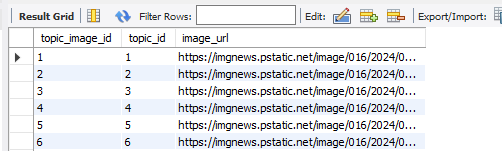

In [ ]:
topic_data = engine.fill_topic_image()


topic_data

In [19]:

def preprocess_topic_image(topic_data):
    image_url = 'https://imgnews.pstatic.net/image/016/2024/03/05/20240305050255_0_20240305103801168.jpg?type=w647'
    topic_image_info = [{'topic_id' :data['topic_id'], 'image_url' : image_url} for data in topic_data] 
    return topic_image_info
topic_image_info = preprocess_topic_image(topic_data)
topic_image_info

[{'topic_id': 501,
  'image_url': 'https://imgnews.pstatic.net/image/016/2024/03/05/20240305050255_0_20240305103801168.jpg?type=w647'},
 {'topic_id': 502,
  'image_url': 'https://imgnews.pstatic.net/image/016/2024/03/05/20240305050255_0_20240305103801168.jpg?type=w647'},
 {'topic_id': 503,
  'image_url': 'https://imgnews.pstatic.net/image/016/2024/03/05/20240305050255_0_20240305103801168.jpg?type=w647'},
 {'topic_id': 504,
  'image_url': 'https://imgnews.pstatic.net/image/016/2024/03/05/20240305050255_0_20240305103801168.jpg?type=w647'},
 {'topic_id': 505,
  'image_url': 'https://imgnews.pstatic.net/image/016/2024/03/05/20240305050255_0_20240305103801168.jpg?type=w647'},
 {'topic_id': 506,
  'image_url': 'https://imgnews.pstatic.net/image/016/2024/03/05/20240305050255_0_20240305103801168.jpg?type=w647'},
 {'topic_id': 507,
  'image_url': 'https://imgnews.pstatic.net/image/016/2024/03/05/20240305050255_0_20240305103801168.jpg?type=w647'},
 {'topic_id': 508,
  'image_url': 'https://imgne

#### TOPIC SUMMARY 채우기

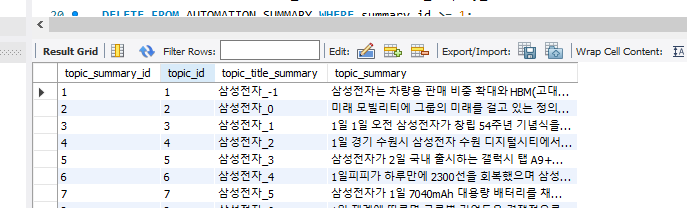

In [ ]:
def fill_topic_summary():
    
    merge_data = engine.select_data_from_db(query = f"""
                                                        SELECT T.topic_id,
                                                            T.startdate,
                                                            T.max_news_id,
                                                            {self.db_config['database']}.NEWS.title,
                                                            {self.db_config['database']}.SUMMARY.summary_text
                                                        FROM (
                                                            SELECT {self.db_config['database']}.NEWS_TOPIC.topic_id, {self.db_config['database']}.TOPIC.startdate, MAX({self.db_config['database']}.NEWS_TOPIC.news_id) AS max_news_id
                                                            FROM {self.db_config['database']}.NEWS_TOPIC
                                                            JOIN {self.db_config['database']}.TOPIC ON {self.db_config['database']}.NEWS_TOPIC.topic_id = {self.db_config['database']}.TOPIC.topic_id
                                                            WHERE {self.db_config['database']}.TOPIC.startdate BETWEEN '{self.start_time}' AND '{self.end_time}'
                                                            GROUP BY {self.db_config['database']}.NEWS_TOPIC.topic_id
                                                        ) AS T
                                                        JOIN {self.db_config['database']}.NEWS ON T.max_news_id = {self.db_config['database']}.NEWS.news_id
                                                        JOIN {self.db_config['database']}.SUMMARY ON T.max_news_id = {self.db_config['database']}.SUMMARY.news_id;
                                                    """, 
                                            description='SELECT NEWS, SUMMARY MERGE TABLE')
    
    topic_summary_info = preprocess_topic_summary(merge_data)

In [ ]:
SELECT T.topic_id,
	   T.startdate,
       T.max_news_id,
       AUTOMATION.NEWS.title,
       AUTOMATION.SUMMARY.summary_text
FROM (
    SELECT AUTOMATION.NEWS_TOPIC.topic_id, AUTOMATION.TOPIC.startdate, MAX(AUTOMATION.NEWS_TOPIC.news_id) AS max_news_id
    FROM AUTOMATION.NEWS_TOPIC
    JOIN AUTOMATION.TOPIC ON AUTOMATION.NEWS_TOPIC.topic_id = AUTOMATION.TOPIC.topic_id
    WHERE AUTOMATION.TOPIC.startdate BETWEEN '2024-03-08 00:00:00' AND '2024-03-08 23:59:59'
    GROUP BY AUTOMATION.NEWS_TOPIC.topic_id
) AS T
JOIN AUTOMATION.NEWS ON T.max_news_id = AUTOMATION.NEWS.news_id
JOIN AUTOMATION.SUMMARY ON T.max_news_id = AUTOMATION.SUMMARY.news_id;

In [6]:
def preprocess_topic_summary(merge_data):
    topic_summary_info = [{'topic_id' : ts_data['topic_id'], 
                            'topic_title_summary' : ts_data['title'],
                            'topic_summary' : ts_data['summary_text']} for ts_data in merge_data]
    return topic_summary_info

topic_summary_info = preprocess_topic_summary(merge_data)
topic_summary_info

[{'topic_id': 401,
  'topic_title_summary': "외인·기관 '사자' 코스피 2680 탈환…바이오·반도체 강세",
  'topic_summary': '미국일 연방준비제도(Fed, 연준) 의장의 의회 발언과 민간 고용지표 발표 등으로 미국의 금리 인하 기대가 재유입되면서 코스피와 코스닥이 상승했다. 8일 코스피는 32.73포인트(1.24%) 상승한 2680.35에 마감했고, 코스닥지수는 873.18, 원·달러 환율은 1319.8원에 마감했다. 기관과 외국인 투자자의 순매수세가 영향을 미쳤다. 의약품, 의약재, 의료정밀, 제조업, 비금속광물, 섬유의복 등이 강세를 보였고, 바이오와 엔터주도 반등했다. 미국 실업률이 예상치를 하회하면 고금리 장기화 우려가 다시 대두될 수 있다는 조언이 나왔다. 다음주 초 단기 리스크로는 연준 대출 프로그램(BTFP) 종료와 미국 2월 소비자 물가 지수(CPI)가 있으며, 다음주 초 단기 리스크로는 연준대출 프로그램(BTFP) 종료와 미국 2월 소비자 물가 지수(CPI)가 있다.'},
 {'topic_id': 402,
  'topic_title_summary': '[단독] "한번 고객을 영원한 고객으로"…기아, AS·CS 조직 강화',
  'topic_summary': "기아는 고객 관리 조직을 강화했다. 고객과 직접 소통하는 '오너십관리사업부'를 설치했다. 이를 통해 고객 만족도를 높이고 재구매에 이르도록 노력할 것이라고 밝혔다. 이를 통해 소프트웨어 중심 차량 시대를 대비하여 고객 관리의 중요성을 강조했다. 또한, 기아는 인도 러시아 등 신흥시장 공략을 위한 조직 개편도 진행했다."},
 {'topic_id': 403,
  'topic_title_summary': '[인터배터리] 김무성, 인터배터리에 깜짝 등장…"엔켐 놀라워"',
  'topic_summary': "김무성 전 새누리당 대표가 국내 최대 배터리 전시회 '인터배터리 2024'에서 VIP 투어를 진행하고 있다. 김 전 대표는 엔켐이 발전 

In [4]:
def preprocess_topic_summary(merge_data):
    

,topic_id,title,summary_text
0,401,외인·기관 '사자' 코스피 2680 탈환…바이오·반도체 강세,"미국일 연방준비제도(Fed, 연준) 의장의 의회 발언과 민간 고용지표 발표 등으로 ..."
1,402,"[단독] ""한번 고객을 영원한 고객으로""…기아, AS·CS 조직 강화",기아는 고객 관리 조직을 강화했다. 고객과 직접 소통하는 '오너십관리사업부'를 설치...
2,403,"[인터배터리] 김무성, 인터배터리에 깜짝 등장…""엔켐 놀라워""",김무성 전 새누리당 대표가 국내 최대 배터리 전시회 '인터배터리 2024'에서 VI...
3,404,"현대차, 중고 전기차 판매 시작…""시장의 활력소 될 것""",기아기아에 이어 현대차도 중고 EV 시장에 진출했다. 현대차는 주행거리 6만km 이...
4,405,6.5만명 찾았다…SK온이 인터배터리서 선보인 기술은,SK온은 서울 강남구 코엑스에서 열린 '인터배터리2024'에서 SF 배터리부터 시작...
...,...,...,...
95,496,"KT&G 상상마당, 실력파 뮤지션 등용문 ‘밴드 디스커버리’ 공모",KT&G가 실력파 인디 뮤지션을 발굴·지원하는 '2024 밴드 디스커버리' 참가 대...
96,497,‘먹튀’ ‘표절’ 논란에도… 침묵하는 카카오[현장에서],카카오그룹의 준법경영 논란에도 불구하고 윤리·준법 경영을 감시하는 외부기구인 준법과...
97,498,"HD현대, 신사업 시동…신재생에너지 PPA 사업 추진",HD현대가 신재생에너지 직접 전력구매계약(PPA) 등 신사업 추진을 위해 친환경 전...
98,499,[코스피 마감]1%대 올라 2680선 복귀…반도체株 ‘강세’,8일 미국 증시가 예상에 부합한 연방준비제도(Fed) 의장의 발언과 반도체 강세 속...


#### NEWS_TOPIC 채우기

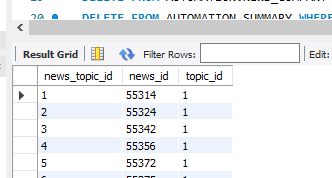
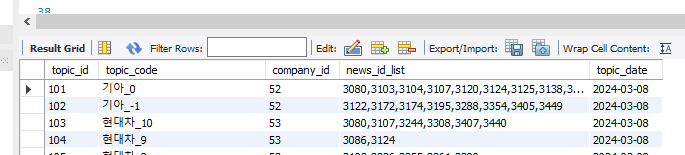

In [10]:
def fill_news_topic(self):
    table_name = 'NEWS_TOPIC'
    start_time, end_time = self.start_time.strftime('%Y-%m-%d %H:%M:%S'), self.end_time.strftime('%Y-%m-%d %H:%M:%S')
    logger.info(f"INSERT {table_name} TABLE START : {start_time} ~ {end_time}")
    
    topic_data = self.select_data_from_db(query = f"SELECT * FROM {self.db_config['database']}.TOPIC WHERE startdate BETWEEN '{self.start_time}' AND '{self.end_time}';", 
                                                description='SELECT TOPIC TABLE')
    
    topic_info = self.preprocess_news_topic(topic_data)
    
    self.

def preprocess_news_topic(self, topic_data):
    news_topic_lst = []

    for info in topic_data:
        topic_id, news_id_lst = info['topic_id'], info['news_id_list'].split(',')
        news_topic_lst.extend([{'news_id' : news_id, 'topic_id' : topic_id} for news_id in news_id_lst])
    return news_topic_lst


In [12]:
def preprocess_news_topic(self, topic_data):
    news_topic_lst = []

    for info in topic_data:
        topic_id, news_id_lst = info['topic_id'], info['news_id_list'].split(',')
        news_topic_lst.extend([{'news_id' : news_id, 'topic_id' : topic_id} for news_id in news_id_lst])
    return news_topic_lst


[{'news_id': '3080', 'topic_id': 201},
 {'news_id': '3103', 'topic_id': 201},
 {'news_id': '3104', 'topic_id': 201},
 {'news_id': '3107', 'topic_id': 201},
 {'news_id': '3120', 'topic_id': 201},
 {'news_id': '3124', 'topic_id': 201},
 {'news_id': '3125', 'topic_id': 201},
 {'news_id': '3138', 'topic_id': 201},
 {'news_id': '3207', 'topic_id': 201},
 {'news_id': '3219', 'topic_id': 201},
 {'news_id': '3244', 'topic_id': 201},
 {'news_id': '3253', 'topic_id': 201},
 {'news_id': '3257', 'topic_id': 201},
 {'news_id': '3268', 'topic_id': 201},
 {'news_id': '3286', 'topic_id': 201},
 {'news_id': '3308', 'topic_id': 201},
 {'news_id': '3321', 'topic_id': 201},
 {'news_id': '3331', 'topic_id': 201},
 {'news_id': '3335', 'topic_id': 201},
 {'news_id': '3343', 'topic_id': 201},
 {'news_id': '3355', 'topic_id': 201},
 {'news_id': '3360', 'topic_id': 201},
 {'news_id': '3361', 'topic_id': 201},
 {'news_id': '3368', 'topic_id': 201},
 {'news_id': '3370', 'topic_id': 201},
 {'news_id': '3379', 'top

In [ ]:
def preprocess_news_topic(topic_data):
    

In [ ]:
    def fill_news_company(self):
        table_name = 'NEWS_COMPANY'
        start_time, end_time = self.start_time.strftime('%Y-%m-%d %H:%M:%S'), self.end_time.strftime('%Y-%m-%d %H:%M:%S')
        logger.info(f"INSERT {table_name} TABLE START : {start_time} ~ {end_time}")        
        # NEWS, COMPANY 데이터 조회, 
        news_data = self.select_data_from_db(query = f"SELECT * FROM {self.db_config['database']}.NEWS WHERE date BETWEEN '{start_time}' AND '{end_time}';", 
                                             description='SELECT NEWS TABLE')
        company_data = self.select_data_from_db(query = f"SELECT * FROM {self.db_config['database']}.COMPANY;",
                                                description='SELECT COMPANY TABLE')
        logger.info(f"NEWS, COMPANY SELECT Done")
        
        # NEWS_COMPANY 테이블에 맞게 전처리
        news_company_info = self.preprocess_news_company(news_data, company_data)
        logger.info(f"{table_name} Preprocessing Done")
        
        # NEWS_COMPANY 테이블에 입력
        self.insert_data_to_db(query=f"INSERT INTO {self.db_config['database']}.{table_name} (news_id, company_id) VALUES (%(news_id)s, %(company_id)s)",
                               data=news_company_info,
                               description=f'INSERT {table_name} TABLES')
        logger.info(f"INSERT {table_name} TABLE DONE : {start_time} ~ {end_time}")

#### Topic 채우기

In [1]:
def fill_topic():
    # NEWS, SUMMARY, COMPANY, NEWS_COMPANY 테이블병합 데이터 조회, 
    merge_data = engine.select_data_from_db(query = f"""
                                                            SELECT 
                                                                AUTOMATION.NEWS.news_id,
                                                                AUTOMATION.SUMMARY.summary_text,
                                                                AUTOMATION.NEWS_COMPANY.company_id,
                                                                AUTOMATION.COMPANY.company_code,
                                                                AUTOMATION.COMPANY.name
                                                            FROM 
                                                                AUTOMATION.NEWS_COMPANY
                                                            JOIN 
                                                                AUTOMATION.NEWS ON AUTOMATION.NEWS_COMPANY.news_id = AUTOMATION.NEWS.news_id
                                                            JOIN 
                                                                AUTOMATION.SUMMARY ON AUTOMATION.NEWS_COMPANY.news_id = AUTOMATION.SUMMARY.news_id
                                                            JOIN 
                                                                AUTOMATION.COMPANY ON AUTOMATION.NEWS_COMPANY.company_id = AUTOMATION.COMPANY.company_id
                                                            WHERE 
                                                                AUTOMATION.NEWS.date BETWEEN '2024-03-08 00:00:00' AND '2024-03-08 23:59:59';
                                           """, 
                                         
                                         description='SELECT NEWS, SUMMARY MERGE TABLE')
    logger.info(f"NEWS, SUMMARY MERGE SELECT Done")
    
    # EMBEDDING 생성
    topic_info = preprocess_topic(merge_data)
    logger.info(f"MAKE EMBEDDING DONE")
    
    return topic_info



def preprocess_topic(merge_data):
    df_merge =  get_embedding_vector(merge_data, model_name = 'leewaay/kpf-bert-base-klueNLI-klueSTS-MSL512')
    topic_info = []

    for stock in df_merge['name'].unique():
        df_stock = df_merge[df_merge['name'] == stock].copy()
        
        logger.info(f"Stock : {stock} Clustering Start, Count : {len(df_stock)} ")
        stock_name, company_id, topic_date = df_stock['name'].unique()[0], df_stock['company_id'].unique()[0], self..today
        
        if len(df_stock) == 1:
            topic_code = f"{stock_name}_0"
            news_id_list = str(df_stock['news_id'].unique()[0])
            topic_info.append({
                                    'topic_code' : topic_code,
                                    'company_id' : company_id,
                                    'news_id_list': news_id_list,
                                    'topic_date' : topic_date
            })
            
        else:
            embedding = df_stock['embedding'].tolist()
            df_clustering, topic_counter = clustering(df_stock, embedding, min_cluster_size=2, min_samples=1, method='eom')
            
            # topic 별로 내용 추출 
            for topic in topic_counter:
                df_topic = df_clustering[df_clustering['Topic'] == topic].copy()
                topic_code = f"{stock_name}_{topic}"
                news_id_list = ','.join(map(lambda x : str(x), df_topic['news_id'].tolist()))
                
                # NEWS, Topic 별 내용 저장
                topic_info.append({
                                        'topic_code' : topic_code,
                                        'company_id' : company_id,
                                        'news_id_list': news_id_list,
                                        'topic_date' : topic_date
                                        })
    return topic_info

    

def get_embedding_vector(summary_data, model_name = 'leewaay/kpf-bert-base-klueNLI-klueSTS-MSL512'):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = SentenceTransformer(model_name).to(device)
    
    df_merge = pd.DataFrame(summary_data)
    df_merge['embedding'] = df_merge['summary_text'].progress_apply(model.encode)
    
    # GPU 메모리 정리
    torch.cuda.empty_cache()
    return df_merge

# HDBSCAN 실행
def clustering(corpus, corpus_embeddings, min_cluster_size=2, min_samples=1, method='eom'):
    cluster = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size,
                              min_samples=min_samples,
                              metric='euclidean',
                              allow_single_cluster=True,
                              cluster_selection_method=method,
                              ).fit(corpus_embeddings) #eom leaf

    docs_df = corpus.copy()
    docs_df['Topic'] = cluster.labels_    
    return docs_df, Counter(cluster.labels_)




In [ ]:
# topic_info = fill_topic()

In [100]:
topic_info

[{'topic_code': '기아_0',
  'company_id': 52,
  'news_id_list': '3080,3103,3104,3107,3120,3124,3125,3138,3207,3219,3244,3253,3257,3268,3286,3308,3321,3331,3335,3343,3355,3360,3361,3368,3370,3379,3387,3390,3400,3404,3407,3411,3421,3440,3444',
  'topic_date': '2024-03-08'},
 {'topic_code': '기아_-1',
  'company_id': 52,
  'news_id_list': '3122,3172,3174,3195,3288,3354,3405,3449',
  'topic_date': '2024-03-08'},
 {'topic_code': '현대차_10',
  'company_id': 53,
  'news_id_list': '3080,3107,3244,3308,3407,3440',
  'topic_date': '2024-03-08'},
 {'topic_code': '현대차_9',
  'company_id': 53,
  'news_id_list': '3086,3124',
  'topic_date': '2024-03-08'},
 {'topic_code': '현대차_8',
  'company_id': 53,
  'news_id_list': '3103,3326,3355,3361,3390',
  'topic_date': '2024-03-08'},
 {'topic_code': '현대차_12',
  'company_id': 53,
  'news_id_list': '3104,3126,3185,3207,3268,3286,3368,3370,3379,3387,3400,3404,3411',
  'topic_date': '2024-03-08'},
 {'topic_code': '현대차_-1',
  'company_id': 53,
  'news_id_list': '3105,31

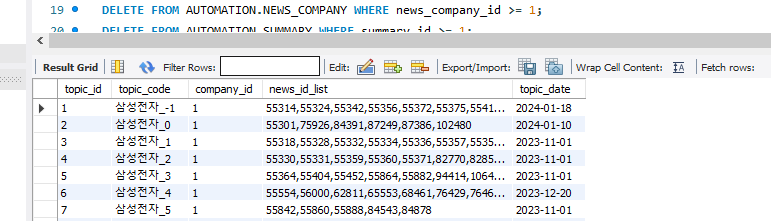

In [70]:
engine.today

'2024-03-08'

In [84]:
import time

In [92]:
def 
topic_info = []

for stock in df_merge['name'].unique():
    df_stock = df_merge[df_merge['name'] == stock].copy()
    
    logger.info(f"Stock : {stock} Clustering Start, Count : {len(df_stock)} ")
    stock_name, company_id, topic_date = df_stock['name'].unique()[0], df_stock['company_id'].unique()[0], engine.today
    
    if len(df_stock) == 1:
        topic_code = f"{stock_name}_0"
        news_id_list = str(df_stock['news_id'].unique()[0])
        topic_info.append({
                                'topic_code' : topic_code,
                                'company_id' : company_id,
                                'news_id_list': news_id_list,
                                'topic_date' : topic_date
        })
        
    else:
        embedding = df_stock['embedding'].tolist()
        df_clustering, topic_counter = clustering(df_stock, embedding, min_cluster_size=2, min_samples=1, method='eom')
        
        # topic 별로 내용 추출 
        for topic in topic_counter:
            df_topic = df_clustering[df_clustering['Topic'] == topic].copy()
            topic_code = f"{stock_name}_{topic}"
            news_id_list = ','.join(map(lambda x : str(x), df_topic['news_id'].tolist()))
            
            # NEWS, Topic 별 내용 저장
            topic_info.append({
                                    'topic_code' : topic_code,
                                    'company_id' : company_id,
                                    'news_id_list': news_id_list,
                                    'topic_date' : topic_date
                                    })
    

2024-03-10 07:57:58.910 | INFO     | __main__:<module>:6 - Stock : 기아 Clustering Start, Count : 43 
2024-03-10 07:57:58.921 | INFO     | __main__:<module>:6 - Stock : 현대차 Clustering Start, Count : 65 
2024-03-10 07:57:58.941 | INFO     | __main__:<module>:6 - Stock : 두산에너빌리티 Clustering Start, Count : 3 
2024-03-10 07:57:58.945 | INFO     | __main__:<module>:6 - Stock : HD현대중공업 Clustering Start, Count : 5 
2024-03-10 07:57:58.949 | INFO     | __main__:<module>:6 - Stock : KT Clustering Start, Count : 3 
2024-03-10 07:57:58.954 | INFO     | __main__:<module>:6 - Stock : 대한항공 Clustering Start, Count : 10 
2024-03-10 07:57:58.958 | INFO     | __main__:<module>:6 - Stock : 삼성전자 Clustering Start, Count : 127 
2024-03-10 07:57:59.004 | INFO     | __main__:<module>:6 - Stock : LG전자 Clustering Start, Count : 39 
2024-03-10 07:57:59.014 | INFO     | __main__:<module>:6 - Stock : KB금융 Clustering Start, Count : 16 
2024-03-10 07:57:59.019 | INFO     | __main__:<module>:6 - Stock : 하나금융지주 Clusterin

In [93]:
pd.DataFrame(topic_info)

,topic_code,company_id,news_id_list,topic_date
0,기아_0,52,"3080,3103,3104,3107,3120,3124,3125,3138,3207,3...",2024-03-08
1,기아_-1,52,"3122,3172,3174,3195,3288,3354,3405,3449",2024-03-08
2,현대차_10,53,"3080,3107,3244,3308,3407,3440",2024-03-08
3,현대차_9,53,"3086,3124",2024-03-08
4,현대차_8,53,"3103,3326,3355,3361,3390",2024-03-08
...,...,...,...,...
95,KT&G_0,76,"3267,3337",2024-03-08
96,카카오뱅크_0,72,3300,2024-03-08
97,SK텔레콤_0,80,"3339,3373",2024-03-08
98,현대모비스_0,63,3368,2024-03-08


In [75]:
','.join(map(lambda x : str(x), df_topic['news_id'].tolist()))


'3080,3103,3104,3107,3120,3124,3125,3138,3207,3219,3244,3253,3257,3268,3286,3308,3321,3331,3335,3343,3355,3360,3361,3368,3370,3379,3387,3390,3400,3404,3407,3411,3421,3440,3444'

In [35]:
topic_data['name'].unique()

array(['기아', '현대차', '두산에너빌리티', 'HD현대중공업', 'KT', '대한항공', '삼성전자', 'LG전자',
       'KB금융', '하나금융지주', '우리금융지주', 'LG', '삼성화재', '삼성물산', 'SK하이닉스', '카카오',
       '셀트리온', '메리츠금융지주', 'NAVER', '삼성SDI', '삼성생명', '한국전력', 'SK이노베이션',
       '삼성전기', '하이브', 'SK스퀘어', '한화에어로스페이스', 'HMM', 'LG에너지솔루션', '포스코퓨처엠',
       'SK', 'POSCO홀딩스', 'LG화학', 'HD한국조선해양', '삼성바이오로직스', '크래프톤', '고려아연',
       'KT&G', '카카오뱅크', 'SK텔레콤', '현대모비스', '신한지주'], dtype=object)

In [ ]:
# HDBSCAN 실행
def hdbscan_process(corpus, corpus_embeddings, min_cluster_size=3, min_samples=3, method='eom'):
    cluster = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size,
                              min_samples=min_samples,
                              metric='euclidean',
                              allow_single_cluster=True,
                              cluster_selection_method=method,
                              ).fit(corpus_embeddings) #eom leaf

    docs_df = corpus
    docs_df['Topic'] = cluster.labels_
    #print(Counter(cluster.labels_), '\n')
    
    return docs_df, Counter(cluster.labels_)

In [30]:
topic_data['embedding'][0]

array([-7.74143934e-01, -2.18981788e-01,  7.24838227e-02, -6.44543529e-01,
        1.94929683e+00, -5.27870297e-01, -5.84082723e-01, -1.10541597e-01,
       -1.77418068e-01, -1.73103130e+00,  6.42364919e-02, -1.57596275e-01,
        6.97672546e-01, -9.46472958e-02,  4.20234054e-01, -1.06432509e+00,
       -2.09190875e-01, -1.33902156e+00,  2.69143462e-01,  8.84159744e-01,
       -4.01351660e-01, -7.07529545e-01,  4.60548759e-01,  1.92720622e-01,
        4.12111551e-01, -8.21257293e-01, -1.23897269e-01,  6.83931336e-02,
        3.32638353e-01, -9.13080037e-01, -3.22177321e-01, -4.67132896e-01,
       -1.07999873e+00,  4.35251296e-01, -3.25644821e-01,  1.00079978e+00,
       -1.63159579e-01,  2.78863106e-02, -6.25296533e-01,  6.28878355e-01,
       -1.50076270e-01, -6.31622851e-01, -2.47668788e-01, -3.19120556e-01,
        5.78499794e-01,  5.43198828e-03, -1.05174792e+00,  2.66926378e-01,
       -8.21033493e-02, -6.25361145e-01,  3.75006616e-01, -3.24429750e-01,
        4.19482231e-01,  

#### SENTIMENT 채우기

In [46]:
def preprocess_sentiemnt(self, news_data, model_path='./model/sentiment', pretrained_model_name_or_path='./model/sentiment'):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path)
    model = AutoModelForSequenceClassification.from_pretrained(pretrained_model_name_or_path, 
                                                            num_labels=3)
    model.to(device)
    model.eval()
    
    sentiment_info = []
    with torch.no_grad():
        for i in tqdm(range((len(news_data) // 30) + 1), desc='SUMMARY WORKING'):
            s_i, e_i = i*30, min((i+1)*30, len(news_data)+1)
            news_id_list = [data['news_id'] for data in news_data[s_i:e_i]]
            title_list = [data['title'] for data in news_data[s_i:e_i]]
            
            # Tokenizing Inputs and Predict
            input = tokenizer(title_list, truncation=True, padding=True, return_tensors='pt').to(device)
            outputs = model(**input)
            predicted_class = torch.argmax(outputs.logits, dim=-1).to('cpu')
            
            for news_id, sentiment in zip(news_id_list, predicted_class.numpy()):
                sentiment_info.append({'news_id' : news_id, 'sentiment_value' : sentiment})

    torch.cuda.empty_cache()
    return sentiment_info

#### Summary 테이블 채우기

In [4]:
def preprocess_summary(news_data, model_path='./model/summary_model.pt', pretrained_model_name_or_path="ainize/kobart-news"):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    # tokenizer 및 모델 로드
    tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path)
    model = torch.load(model_path)
    model.to(device)
    model.eval()
    
    summary_info = [] 
    with torch.no_grad():
        for i in tqdm(range((len(news_data) // 30) + 1), desc='SUMMARY WORKING'):
            s_i, e_i = i*30, min((i+1)*30, len(news_data)+1)
            news_id_list = [data['news_id'] for data in news_data[s_i:e_i]]
            contents_list = [data['contents'] for data in news_data[s_i:e_i]]

            # input data encoding
            inputs = tokenizer.batch_encode_plus(contents_list, 
                                                return_tensors="pt", 
                                                padding=True, 
                                                truncation=True, 
                                                max_length=1026).to(device)

            # Batch generate
            outputs = model.generate(inputs['input_ids'],
                                        bos_token_id=tokenizer.bos_token_id,
                                        eos_token_id=tokenizer.eos_token_id,
                                        length_penalty=1.0,
                                        max_length=300,
                                        min_length=50,
                                        num_beams=6).to("cpu")
            
            decoded_output = tokenizer.batch_decode(outputs, skip_special_tokens=True)
            
            for news_id, summary_text in zip(news_id_list, decoded_output):
                summary_info.append({'news_id' : news_id, 'summary_text':summary_text})


    torch.cuda.empty_cache()
    return summary_info


In [ ]:
summay_info = preprocess_summary(news_data, model_path='./model/summary_model.pt', pretrained_model_name_or_path="ainize/kobart-news")

### news_copmany 테이블 채우기

In [38]:
def fill_news_company():
    news_and_company_data = engine.select_news_and_company_table_with_date()
    return news_and_company_data

news_and_company_data = fill_news_company()


In [ ]:
# (2) 뉴스 전처리
def preprocess_news_company(news_and_company_data):
    """news_table과 company_table에서 조회한 데이터를 활용하여, news_company 데이터의 입력 데이터를 생성"""
    company_info, news_company_info = {}, []
    for info in news_and_company_data['company_table']:
        company_info[info['name']] = info['company_id']


    for info in news_and_company_data['news_table']:
        news_id, relate_stocks = info['news_id'], info['relate_stock'].split(',')
        for stock in relate_stocks:
            news_company_info.append({'news_id': news_id, 'company_id' : company_info[stock]})
    
    return news_company_info

         
news_company_info = preprocess_news_company(news_and_company_data)
news_company_info


In [ ]:
# (3) 데이터 업데이트
def update_news_company_table():
    pass




In [48]:
import asyncio
from crawling import RestClient, NewsCrawler
from datetime import datetime

from collections import Counter
import pandas as pd
from functools import reduce

In [2]:
# 현재 날짜를 '2024-03-07' 형태로 포맷팅
today = datetime.now().strftime('%Y-%m-%d')
today

'2024-03-07'

In [3]:
loop = asyncio.get_event_loop()
client = RestClient(loop)
crwaler = NewsCrawler(client)

today = datetime.now().strftime('%Y-%m-%d')

await asyncio.gather(
        crwaler.crawling_news_url(start_date=today, end_date=today, section='주요뉴스', save_dir=f'./data/mainnews_url.csv'),
        crwaler.crawling_news_url(start_date=today, end_date=today, section='기업/종목분석', save_dir=f'./data/companynews_url.csv'),
        crwaler.crawling_news_url(start_date=today, end_date=today, section='공시/메모', save_dir=f'./data/disclosurenews_url.csv')
    )
# crwaler.dynamic_crawling_news_url(start_date=today, end_date=today, save_dir=f'./data/economynews_url.csv')


await asyncio.gather(
        crwaler.crawling_news_contents(url_data_path=f'./data/mainnews_url.csv', merge_data_path=f'./data/mainnews_all.csv'),
        crwaler.crawling_news_contents(url_data_path=f'./data/companynews_url.csv', merge_data_path=f'./data/companynews_all.csv'),
        crwaler.crawling_news_contents(url_data_path=f'./data/disclosurenews_url.csv', merge_data_path=f'./data/disclosurenews_all.csv'),
        # crwaler.crawling_news_contents(url_data_path=f'./data/economynews_url.csv', merge_data_path=f'./data/economynews_all.csv')
    )

2024-03-07 21:49:38.717 | INFO     | crawling:crawling_news_url:267 - 주요뉴스 NEWS CRAwLING START!!
  0%|          | 0/1 [00:00<?, ?it/s]2024-03-07 21:49:38.749 | INFO     | crawling:crawling_news_url:267 - 기업/종목분석 NEWS CRAwLING START!!


2024-03-07 21:49:38.752 | INFO     | crawling:crawling_news_url:267 - 공시/메모 NEWS CRAwLING START!!


100%|██████████| 1/1 [00:00<00:00,  2.35it/s]
2024-03-07 21:49:39.182 | INFO     | crawling:crawling_news_url:291 - MAIN NEWS CRAwLING END!! - TOTAL URL : 55
2024-03-07 21:49:39.186 | INFO     | crawling:crawling_news_url:295 - MAIN NEWS CRAWLING DATA SAVED!! DIR : ./data/disclosurenews_url.csv
100%|██████████| 1/1 [00:01<00:00,  1.12s/it]
2024-03-07 21:49:39.846 | INFO     | crawling:crawling_news_url:291 - MAIN NEWS CRAwLING END!! - TOTAL URL : 224
2024-03-07 21:49:39.849 | INFO     | crawling:crawling_news_url:295 - MAIN NEWS CRAWLING DATA SAVED!! DIR : ./data/mainnews_url.csv
100%|██████████| 1/1 [00:01<00:00,  1.54s/it]
2024-03-07 21:49:40.289 | INFO     | crawling:crawling_news_url:291 - MAIN NEWS CRAwLING END!! - TOTAL URL : 188
2024-03-07 21:49:40.294 | INFO     | crawling:crawling_news_url:295 - MAIN NEWS CRAWLING DATA SAVED!! DIR : ./data/companynews_url.csv
  0%|          | 0/

[None, None, None]

In [6]:
df_main = pd.read_csv('./data/mainnews_all.csv')
df_company = pd.read_csv('./data/companynews_all.csv')
df_disclosure = pd.read_csv('./data/disclosurenews_all.csv')
df_economy = pd.read_csv('./data/economynews_all.csv')

In [7]:
def new_relate_news(lst):
    relate_news = []
    counter = Counter(lst)

    for stock in counter:
        if stock in ['SK', 'LG', 'KT'] :
            if counter[stock] >= 5:
                relate_news.append(stock)
        else:
            relate_news.append(stock)
    
    return relate_news

In [73]:
from datetime import datetime, timedelta

# 현재 시간 가져오기
current_time = datetime.now().replace(minute=0, second=0, microsecond=0)

# 3시간 전 시간 계산
three_hours_ago = (current_time - timedelta(hours=3))
one_hours_ago = (current_time - timedelta(hours=2))
print("현재 시간:", current_time.strftime("%Y-%m-%d %H:%M:%S"))
print("3시간 전 시간:", three_hours_ago.strftime("%Y-%m-%d %H:%M:%S"))

현재 시간: 2024-03-07 22:00:00
3시간 전 시간: 2024-03-07 19:00:00


In [74]:
# 날짜와 시간 형식 지정
formatted_time = current_time.strftime("%Y-%m-%d %H:%M:%S")
print("형식 지정된 시간:", formatted_time)

형식 지정된 시간: 2024-03-07 22:00:00


In [ ]:
df_news[(df_news['datetime'] > three_hours_ago) & (df_news['datetime'] <= current_time)]

In [55]:
df_news = pd.concat([df_main, df_company, df_disclosure, df_economy])
df_news = df_news[['datetime', 'url', 'real_title', 'contents', 'relate_stock']].rename({'real_title' : 'title'}, axis=1)

# url 기준으로 중복 뉴스 제거
df_news.drop_duplicates(subset=['url'], inplace=True)
df_news.reset_index(drop=True, inplace=True)

# datetime 형식 변경 : 오후 12시 : 24시 --> 12시
df_news['datetime'] = pd.to_datetime(df_news['datetime'].apply(lambda x : x.replace("24:", "12:")))

# relate_stock 전처리 : SK, LG, KT는 5번 이상 나와야 인정하고 나머지는 1번만 나와도 인정하자./ ,으로 연결
df_news['relate_stock'] = df_news['relate_stock'].apply(lambda x : new_relate_news(eval(x)))
df_news = df_news[df_news['relate_stock'].apply(lambda x : len(x) > 0)]
df_news['relate_stock'] = df_news['relate_stock'].apply(lambda lst : reduce(lambda acc, cur : acc+','+cur, lst))

# contents가 NaN이고, title에 [속보]가 포함되면 contents에 title을 넣음.
mask = (df_news['title'].str.contains('속보')) & (df_news['contents'].isna())
df_news.loc[mask, 'contents'] = df_news.loc[mask, 'title']

# contents 길이가 5000이하인 뉴스들만 선별
df_news = df_news[df_news['contents'].apply(lambda x : len(x) < 5000)]

news_info = df_news.to_dict(orient='index')
news_info_lst = [news_info[idx] for idx in news_info]

[{'datetime': Timestamp('2024-03-07 19:53:00'),
  'url': 'https://n.news.naver.com/mnews/article/215/0001151854',
  'title': "'시너지 강화' 기우는 차기 CEO경쟁…2파전 압축",
  'contents': 'NH투자증권 차기 대표 선임 2파전 압축"유찬형 전 부회장 그룹 시너지 창출 적임자...윤병운 부사장 IB황금기 영업통"증권·글로벌 강화 시급한 NH금융...지주간 순위경쟁, 시너지 강화 방점 NH투자증권 차기 대표이사 인선이 윤병운 NH투자증권 부사장과 유찬형 전 농협중앙회 부회장의 2파전으로 굳어지고 있다.금융투자업계에서는 IB(투자은행) 명가의 지속이냐, 아니면 NH농협금융지주와의 시너지 확대냐가 차기 대표 선임 결정의 변수가 될 것이란 관측이 나온다. 7일 금융투자업계에 따르면 NH투자증권은 오는 11일 임원후보추천위원회를 열고 차기 대표이사 후보 1명을 확정해 12일 임시 이사회에서 발표할 예정이다.차기 대표이사 숏리스트 발표를 앞두고 정영채 대표이사가 돌연 용퇴를 결정하면서, 지난 5일 발표된 최종 후보군에는 윤병운 IB1사업부 대표(부사장)과 유찬형 전 농협중앙회 부회장, 사재훈 전 삼성증권 부사장 3명이 올랐다.하지만 업계에서는 사실상 윤 부사장과 유 전 부회장의 2파전으로 보는 시각이 우세하다. 먼저 윤병운 부사장은 NH투자증권의 IB사업을 총괄하며, 유일한 내부 출신 차기 대표 후보로 떠올랐다. 지난해 말 인사에서 최승호 IB2사업부 대표(부사장)와 권순호 OCIO 대표(전무)가 계약 해지되면서 사실상 내부에선 차기 CEO 후보군 밑작업을 마쳤다는 분석이 나온다.윤 부사장은 1993년 NH투자증권의 전신인 LG투자증권에 입사해 줄곧 NH투자증권에서 자리를 지켜왔고, 특히 정영채 대표와 함께 20여년 동안 호흡을 맞춰 NH투자증권의 IB 황금기를 연 영업통으로 꼽힌다. 지난해에는 오스템임플란트와 루트로닉 공개매수 M&A를 주관해, 주관업무뿐 

In [53]:
df_all

,datetime,url,title,contents,relate_stock
0,2024-03-07 19:53:00,https://n.news.naver.com/mnews/article/215/000...,'시너지 강화' 기우는 차기 CEO경쟁…2파전 압축,"NH투자증권 차기 대표 선임 2파전 압축""유찬형 전 부회장 그룹 시너지 창출 적임자...","메리츠금융지주,우리금융지주"
1,2024-03-07 19:12:00,https://n.news.naver.com/mnews/article/029/000...,"""이젠 부동산으로""… 전문가들 몸값 `껑충`","금융권, 부동산 컨설팅분야 강화우리, 시장 최대어 함영진 영입NH 김열매 연구원은 ...",삼성물산
2,2024-03-07 18:16:00,https://n.news.naver.com/mnews/article/014/000...,코스피200 80% 외국인 지분율 증가,실적주·저PBR주 집중 매집작년 12월부터 매수 우위 유지석 달 동안 16조 넘게 ...,"현대차,LG화학,삼성물산,삼성SDI,KB금융,우리금융지주"
3,2024-03-07 18:15:00,https://n.news.naver.com/mnews/article/015/000...,'트럼프 대세론' 뜰수록 불붙는 K방산주,LIG넥스원·한화에어로 고공비행중동 등 지정학적 리스크 부각韓 방산기업 연매출 20...,한화에어로스페이스
4,2024-03-07 18:07:00,https://n.news.naver.com/mnews/article/015/000...,전 세계 반도체株 시총 1경원 육박,생성형 AI 기대감…5년새 5배엔비디아·ASML 등이 이끌어이 기사는 국내 최대 해...,"삼성전자,SK하이닉스"
...,...,...,...,...,...
701,2024-03-07 03:58:00,https://n.news.naver.com/mnews/article/023/000...,"“머스크는 테크노 파시스트”... 환경단체, 6조 테슬라공장에 전대미문 테러",악재 겹쳐 이틀새 시총 100조 증발 5일(현지 시각) 독일 베를린 인근에 있는 테...,SK하이닉스
703,2024-03-07 03:04:00,https://n.news.naver.com/mnews/article/658/000...,금양 꿈의 이차전지 첫 영접…“양산 언제냐” 질문 쏟아져,인터배터리 2024- 전시장 1층 최대 규모…첫 참가- 원통형 배터리 4695 중앙...,"삼성SDI,LG에너지솔루션,고려아연"
704,2024-03-07 03:02:00,https://n.news.naver.com/mnews/article/023/000...,‘PASS 스마트 항공권’ 대한항공·진에어 추가,"SK텔레콤, KT, LG유플러스와 한국공항공사는 전국 국내선 공항 14곳에서 통신 ...","대한항공,SK텔레콤"
705,2024-03-07 03:01:00,https://n.news.naver.com/mnews/article/023/000...,지난달 전세계 선박 발주량… 국내 조선사가 절반 싹쓸이,중국 제치고 수주량 1위 차지 지난달 국내 조선사들이 전 세계에서 발주된 선박의 5...,HD한국조선해양


In [ ]:
mask = (df['title'].str.contains('속보')) & (df['contents'].isna())
df.loc[mask, 'contents'] = df.loc[mask, 'title']